# Asian Option pricing using quantum algorithm for Monte Carlo on Amazon Braket

In this notebook we will implement a simple educational example of performing Quantum Monte Carlo estimation of Asian call option on Amazon Braket using Pennylane's `QuantumMonteCarlo` module and `lightning.default` simulator.

First we begin by importing Pennylane and supporting modules for analysis and plotting.

In [1]:
import pennylane as qml
import numpy as np
import scipy
import scipy.stats
from time import time
import matplotlib.pyplot as plt

### Define Asian call option

In finance, a derivative is defined as a contract between two involved parties who can benefit from varying prices of an underlying asset such as a stock or a bond. An **Option** is a type of derivative that grants the holder the right to either buy (**call option**) or sell (**put option**) the underlying asset at a pre-agreed price (the **strike price**) at or within a specified time frame (called the "maturity time" or "exercise window"). The holder only pays for the right to exercise the option which allows the holder the choice whether or not to exercise at the maturity time. If the holder to chooses to exercise the option, the seller must buy or sell the underlying asset as agreed in the contract. Pricing of an option refers to determining the amount the holder must pay in order to purchase the contract. The expected payoff function at time $T$ is given as follows:

$$
    f\left(S_T\right) = max\left(0,S_T-K\right) \qquad \qquad               (1)
$$

with $S_T$ being the value of the underlying asset at time $T$ and $K$ being the strike price.

The task of pricing an option then becomes to determine the expectation value of the payoff function defined above, at present time. In simple cases under a few assumptions, the Black-Scholes-Merton (BSM) model [4, 5] can be used to determine the value of the underlying asset, thereby determining the payoff function. The asset price $S(t)$ is treated as a random variable $X$ that follows a known, or often assumed log-normal, stochastic process. The BSM differential equation is given as follows:

$$
    dX_t = X_t \alpha dt+X_t \sigma dW_t \qquad\qquad                        (2)
$$

where $X_t$ is the asset price at time $t$, $\alpha$ is called the "drift", $\sigma$ is the volatility, and $dW_t$ is the increment of an accompanying Browning motion. In simple cases, with constant drift and volatility, eq. (2) can be analytically solved. However, beyond simple cases, one needs to reply on running Monte Carlo sampling to solve eq. (2) and determine the asset price. 

Here, we will work with the example of an Asian call option which has the following payoff function:

$$
    f\left(A_T\right) = \max(A_T -K, 0) \qquad \qquad (3)
$$

where $K$ is the strike price and $A_T$ is the average asset price computed over the maturity time $T$. Here we will use geometric averaging to compute $A_T$: 

$$
    A_T = \exp\left(\frac{1}{T} \int_0^T \ln{(S(t))} dt \right)\qquad \qquad 	(4)
$$

For constant drift and volatility, the payoff function in eq. (4) can be computed analytically. In practice, arithmetic averaging is sometimes used instead of geometric averaging; arithmetic averaging does not have an analytic solution, so one needs to use numerical methods. In this work, we will work with the geometric case for simplicity.

To start, let's define the parameters of the Asian option: The initial value of the asset price today, called the spot price (`S0`), the strike price (`K`), the risk free rate (`r`), volatility (`sigma`) and the maturity time in years (`T`) with a number of `periods` for averaging.

In [2]:
S0 = 100  # spot price
K = 100  # strike price
r = 0.05  # risk free rate
sigma = 0.2  # volatility
T = 1  # time (e.g. in years)
periods = 2

We will use a normal distribution, characterized by zero mean and `variance` to mimic the probability distribution underlying the asset. This is an assumption for demonstration purposes in this notebook. One can consider variety of other probability distributions. We have defined a `cutoff_factor` which determines the spread of the distribution being consider in the simulation. 

In [3]:
variance = 1 # Variance of the Normal Distribution being used.
cutoff_factor = 4

### Parameters of QMC:
Number of discretization qubits: The number of qubits `n_disc` required to discretize the probability distribution and the random variable representing the asset price.

Number of phase estimation qubits: The number of phase estimation qubits `n_pe` used to apply Quantum Monte Carlo sampling. 

In [4]:
n_disc = 4
n_pe = 5

# Payoff function: Asian Call

In [5]:
def asian_payoff_func(spot, strike, rate, volatility, time, x):
    Dt = time / periods
    payoffs = []
    for item in x:
        price = [spot]
        price.append(price[-1] * np.exp(volatility * item
                                            + (rate - 0.5 * volatility ** 2) * Dt))
        price = np.expand_dims(np.array(price[1:]), axis=0)
        payoff = asian_call_payoffs(price, strike, spot)[0]
        payoffs.append(payoff)
    if np.max(payoffs) == 0:
        payoffs[0] = 1e-10
    return np.array(payoffs)*np.exp(- rate * time)

def asian_call_payoffs(paths, strike, spot, payoff_type = 'geometric'):
    spots = np.full((paths.shape[0], 1), spot)
    paths = np.append(spots, paths, axis=1)
    
    if payoff_type == 'geometric':
        means = scipy.stats.mstats.gmean(paths, axis=1)
    elif payoff_type == 'arithmetic':
        means = np.mean(paths, axis=1)
    else:
        raise Exception('Error: payoff_type must be either geometric or arithmetic')
    asian_payoffs = means - strike
    asian_payoffs[asian_payoffs < 0] = 0

    return asian_payoffs

#### Probability distribution

In [6]:
def normal_dist(n, variance, cutoff_factor):
    dim = 2 ** n
    cutoff_tmp = cutoff_factor * np.sqrt(variance)
    points = np.linspace(-cutoff_tmp, cutoff_tmp, num=dim)
    prob = (1 / np.sqrt(2 * np.pi * variance)) * np.exp(- 0.5 * points ** 2 / variance)
    prob_renorm = prob / np.sum(prob)
    return [points, prob_renorm]

#### QMC for Asian Option

In [7]:
def QMC_Asian_call(spot=100, strike=100, rate=0.05, volatility=0.2, time=1, 
                   variance=1.0, cutoff_factor=4, n_disc=4, n_pe=10):

    N_disc, N_pe = 2**n_disc, 2**n_pe
    
    x, p = normal_dist(n_disc, T, cutoff_factor)
    asian_payoff = asian_payoff_func(spot, strike, rate, volatility, time, x)
    normalization_factor = max(asian_payoff)
    payoff_func = lambda i: asian_payoff[i]/normalization_factor
    
    target_wires = range(n_disc+1)
    estimation_wires = range(n_disc+1, n_disc+n_pe+1)
    
    dev = qml.device("lightning.qubit", wires=(n_disc+n_pe+1))    
    @qml.qnode(dev)
    def circuit():
        qml.templates.QuantumMonteCarlo(
            p,
            payoff_func,
            target_wires=target_wires,
            estimation_wires=estimation_wires,
        )
        return qml.probs(estimation_wires)
    
    phase_estimated = np.argmax(circuit()[:int(N_pe / 2)]) / N_pe
    
    estimated_value_qmc = (1 - np.cos(np.pi * phase_estimated)) / 2 * normalization_factor
        
    return np.array(estimated_value_qmc)

# Benchmarking

Determine the option price with the default values chosen in the previous cell.

In [8]:
t1 = time()
results = QMC_Asian_call()
t2 = time()
print('Results:', results, "time:", t2 - t1)

Results: 4.492103185359647 time: 0.08146905899047852


We now compute the prices for varying values of `n_disc` for a given range of `n_pe` to understand how the error scales.

In [9]:
def asian_qmc_price(n_d):
    npe = range(4, 17)
    time_npe = []
    price_npe = []
    for n_pe in npe:
        t1 = time()
        price_npe.append(QMC_Asian_call(n_disc=n_d, n_pe=n_pe))
        t2 = time()
        time_npe.append(t2-t1)
        print('nd {} and npe:'.format(n_d), n_pe, 'time:', t2-t1)
    return price_npe, time_npe


In [10]:
n_d = np.arange(2, 7)
prices = []
for n in n_d:
    prices.append(asian_qmc_price(n))

nd 2 and npe: 4 time: 0.01605963706970215
nd 2 and npe: 5 time: 0.013904809951782227
nd 2 and npe: 6 time: 0.012968778610229492
nd 2 and npe: 7 time: 0.02362513542175293
nd 2 and npe: 8 time: 0.018481969833374023
nd 2 and npe: 9 time: 0.02072286605834961
nd 2 and npe: 10 time: 0.027335166931152344
nd 2 and npe: 11 time: 0.033867835998535156
nd 2 and npe: 12 time: 0.056383371353149414
nd 2 and npe: 13 time: 0.19801974296569824
nd 2 and npe: 14 time: 0.11357951164245605
nd 2 and npe: 15 time: 0.2190101146697998
nd 2 and npe: 16 time: 0.3504161834716797
nd 3 and npe: 4 time: 0.014694929122924805
nd 3 and npe: 5 time: 0.015142679214477539
nd 3 and npe: 6 time: 0.02066326141357422
nd 3 and npe: 7 time: 0.024506092071533203
nd 3 and npe: 8 time: 0.019420862197875977
nd 3 and npe: 9 time: 0.02434086799621582
nd 3 and npe: 10 time: 0.03031754493713379
nd 3 and npe: 11 time: 0.08733010292053223
nd 3 and npe: 12 time: 0.12111449241638184
nd 3 and npe: 13 time: 0.17804598808288574
nd 3 and npe: 1

In [11]:
price_nd4 = prices[2][0]
price_nd6 = prices[4][0]

npe = range(4, 17)
N_QMC = [2**item for item in npe]
error_nd4 = [np.abs((price_nd4[-1]-item))/K for item in price_nd4]
error_nd6 = [np.abs((price_nd6[-1]-item))/K for item in price_nd6]

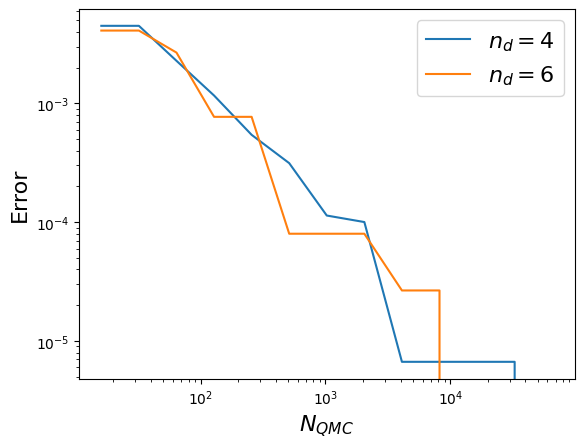

In [12]:
plt.plot(N_QMC, error_nd4)
plt.plot(N_QMC, error_nd6)
plt.legend([r'$n_d=4$', r'$n_d=6$'], fontsize=16)
plt.xlabel(r"$N_{QMC}$", fontsize=16)
plt.ylabel(r"Error", fontsize=16)
plt.yscale('log')
plt.xscale('log')

Now let's determine the scaling exponent by fitting to a power law.

`Quantum scaling exponent`: An exponent of error scaling when the error is fitted to a power-law function $y = A k^\zeta$, where $k$ refers to the number of Monte Carlo samples, and $\zeta$ is the scaling exponent.

In [13]:
from scipy.optimize import curve_fit

In [14]:
def log_powerlaw(x, A, B):
    y = A + B*x
    return y

In [15]:
fitparams = []
xdata = [2**item for item in npe]
for idx, n in enumerate(n_d):
    ydata_tmp = np.array([prices[idx][0][i] for i in range(len(xdata))])
    ydata = np.abs(ydata_tmp - ydata_tmp[-1])
    fitparams.append(curve_fit(log_powerlaw, np.log(xdata[:-4]), np.log(ydata[:-4])))

Comparing run for $n_d = 6$: The figure below shows the comparison of error scaling obtained from classical and quantum algorithms for Monte Carlo estimation for Spot price $\$100$, strike price $\$100$, risk free rate 0.05 %, Volatility of 0.2 and maturity time one year with two time-intervals for averaging. We fix $n_d=6$ as an example. We quantify the overall scaling by fitting the error to a function $y=Ax^\zeta$, where A is the coefficient and $\zeta$ is the scaling exponent. For classical Monte Carlo the scaling exponent is known to be $\zeta_C=-0.5$.  The fitting reveals that for QMC, $\zeta_Q=-0.986$, giving rise to a nearly quadratic speedup of $\zeta_Q/\zeta_C=1.972$.

In [16]:
zeta_q = [fitparams[i][0][-1] for i in range(len(fitparams))]
A_q = [fitparams[i][0][0] for i in range(len(fitparams))]
zeta_q_delta = [fitparams[i][-1][-1][-1] for i in range(len(fitparams))]

In [17]:
fit6 = np.exp(A_q[-1] + zeta_q[-1] * np.log(np.array(xdata)))
classical_scaling = np.exp(A_q[-1] - 0.5 * np.log(np.array(xdata)))

In [18]:
error_nd6 = prices[-1][0] - prices[-1][0][-1]

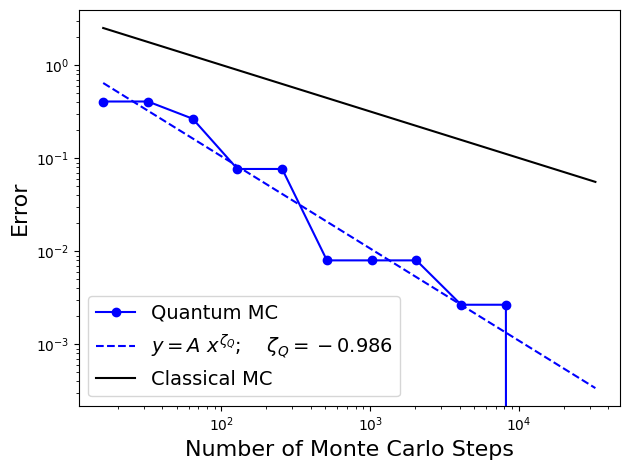

In [19]:
plt.plot(xdata[:-2], np.abs(error_nd6[:-2]), 'o-', color='blue')
plt.plot(xdata[:-1], fit6[:-1], '--', color='blue')
plt.plot(xdata[:-1], classical_scaling[:-1], '-', color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend([r"Quantum MC", r"$y = A~x^{\zeta_Q}$; $~~~\zeta_Q=-0.986$", "Classical MC"], fontsize=14)
plt.xlabel("Number of Monte Carlo Steps", fontsize=16)
plt.ylabel("Error", rotation=90, fontsize=16)
plt.tight_layout()
plt.savefig("quadratic_scaling_asian.png")

In [20]:
zeta_q = [fitparams[i][0][-1] for i in range(len(fitparams))]
A_q = [fitparams[i][0][0] for i in range(len(fitparams))]
zeta_q_delta = [fitparams[i][-1][-1][-1] for i in range(len(fitparams))]

Now, we repeat the Asian call option estimation for a range of values of $n_d$ and plot the ratio of quantum to classical scaling exponents $\zeta_Q/\zeta_C$. A nearly quadratic speedup is obtained for larger values of $n_d$ while for smaller values the speedup is below quadratic. This is expected as lower values of $n_d$ can cause higher errors due to discretization which may in turn impact the overall speed-up of QMC. 

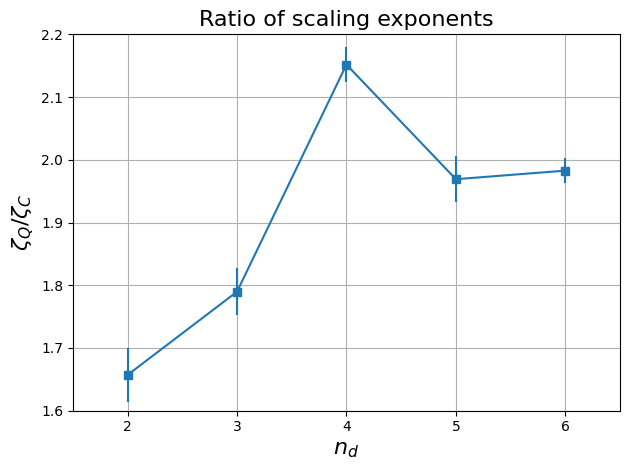

In [21]:
plt.errorbar(n_d, 2*np.abs(np.array(zeta_q)), yerr=2*np.abs(zeta_q_delta), marker='s')
plt.ylim([1.6,2.2])
plt.xlim([1.5,6.5])
plt.title("Ratio of scaling exponents", fontsize=16)
plt.ylabel(r"$\zeta_Q/\zeta_C$", fontsize=16)
plt.xlabel(r"$n_d$", fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("quadratic_scaling_asian_zeta.png")

Walltime of simulations: The CPU time used to perform the simulation. 

In [22]:
timings = [prices[i][1] for i in range(len(prices))]

Let us now compare the runtime of the simulations performed here. The figure below represents the computational wall-time plotted against npe for different values of $n_d$. The wall-time grows exponentially with increasing npe  for each $n_d$. Also, for a fixed $n_{pe}$, a higher $n_d$ results in longer simulation wall-time.

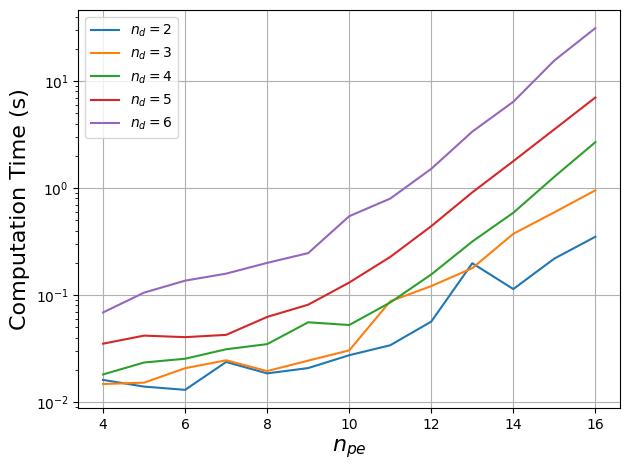

In [23]:
for i, timedata in enumerate(timings):
    plt.plot(npe, timedata)
plt.ylabel(r"Computation Time (s)", fontsize=16)
plt.xlabel(r"$n_{pe}$", fontsize=16)
plt.legend([r"$n_d= 2$", r"$n_d= 3$", r"$n_d= 4$", r"$n_d= 5$", r"$n_d= 6$"])
plt.yscale('log')
plt.tight_layout()
plt.grid()
plt.savefig("quadratic_scaling_asian_time.png")